In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
print(sys.path)

['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/data/isa/mlex/venv/lib/python3.11/site-packages', '/data/isa/mlex']


In [4]:
import arff
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data_path = r'/data/isa/EEG_Eye_State.arff'

with open(data_path, 'r') as f:
    raw = arff.load(f)

columns = [attr[0] for attr in raw['attributes']]
df = pd.DataFrame(raw['data'], columns=columns)

start_time = pd.Timestamp('2025-01-01 00:00:00.000')
interval = pd.to_timedelta('7.8ms')

# Gerando a coluna Timestamp
df['Timestamp'] = [start_time + i * interval for i in range(len(df))]

# Exibindo as primeiras linhas para verificar
print(df.head())

attributes = raw['attributes'] + [('Timestamp', 'STRING')]  # adiciona a nova coluna como string

arff_data = {
    'description': '',
    'relation': 'EEG_Eye_State_with_Timestamp',
    'attributes': attributes,
    'data': df.values.tolist()
}

# Exporta para .arff
output_path = '/data/isa/EEG_Eye_State_com_timestamp.arff'
with open(output_path, 'w') as f:
    arff.dump(arff_data, f)

print(f"Arquivo salvo com sucesso em: {output_path}")

df

FileNotFoundError: [Errno 2] No such file or directory: '/data/isa/EEG_Eye_State.arff'

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from copy import deepcopy
from mlex.features.sequences import SequenceTransformer
from mlex import FeatureStratifiedSplit
from mlex import PreProcessingTransformer
from mlex import DataReader
from mlex import StandardEvaluator
from mlex import F1MaxThresholdStrategy


/data/isa/mlex/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


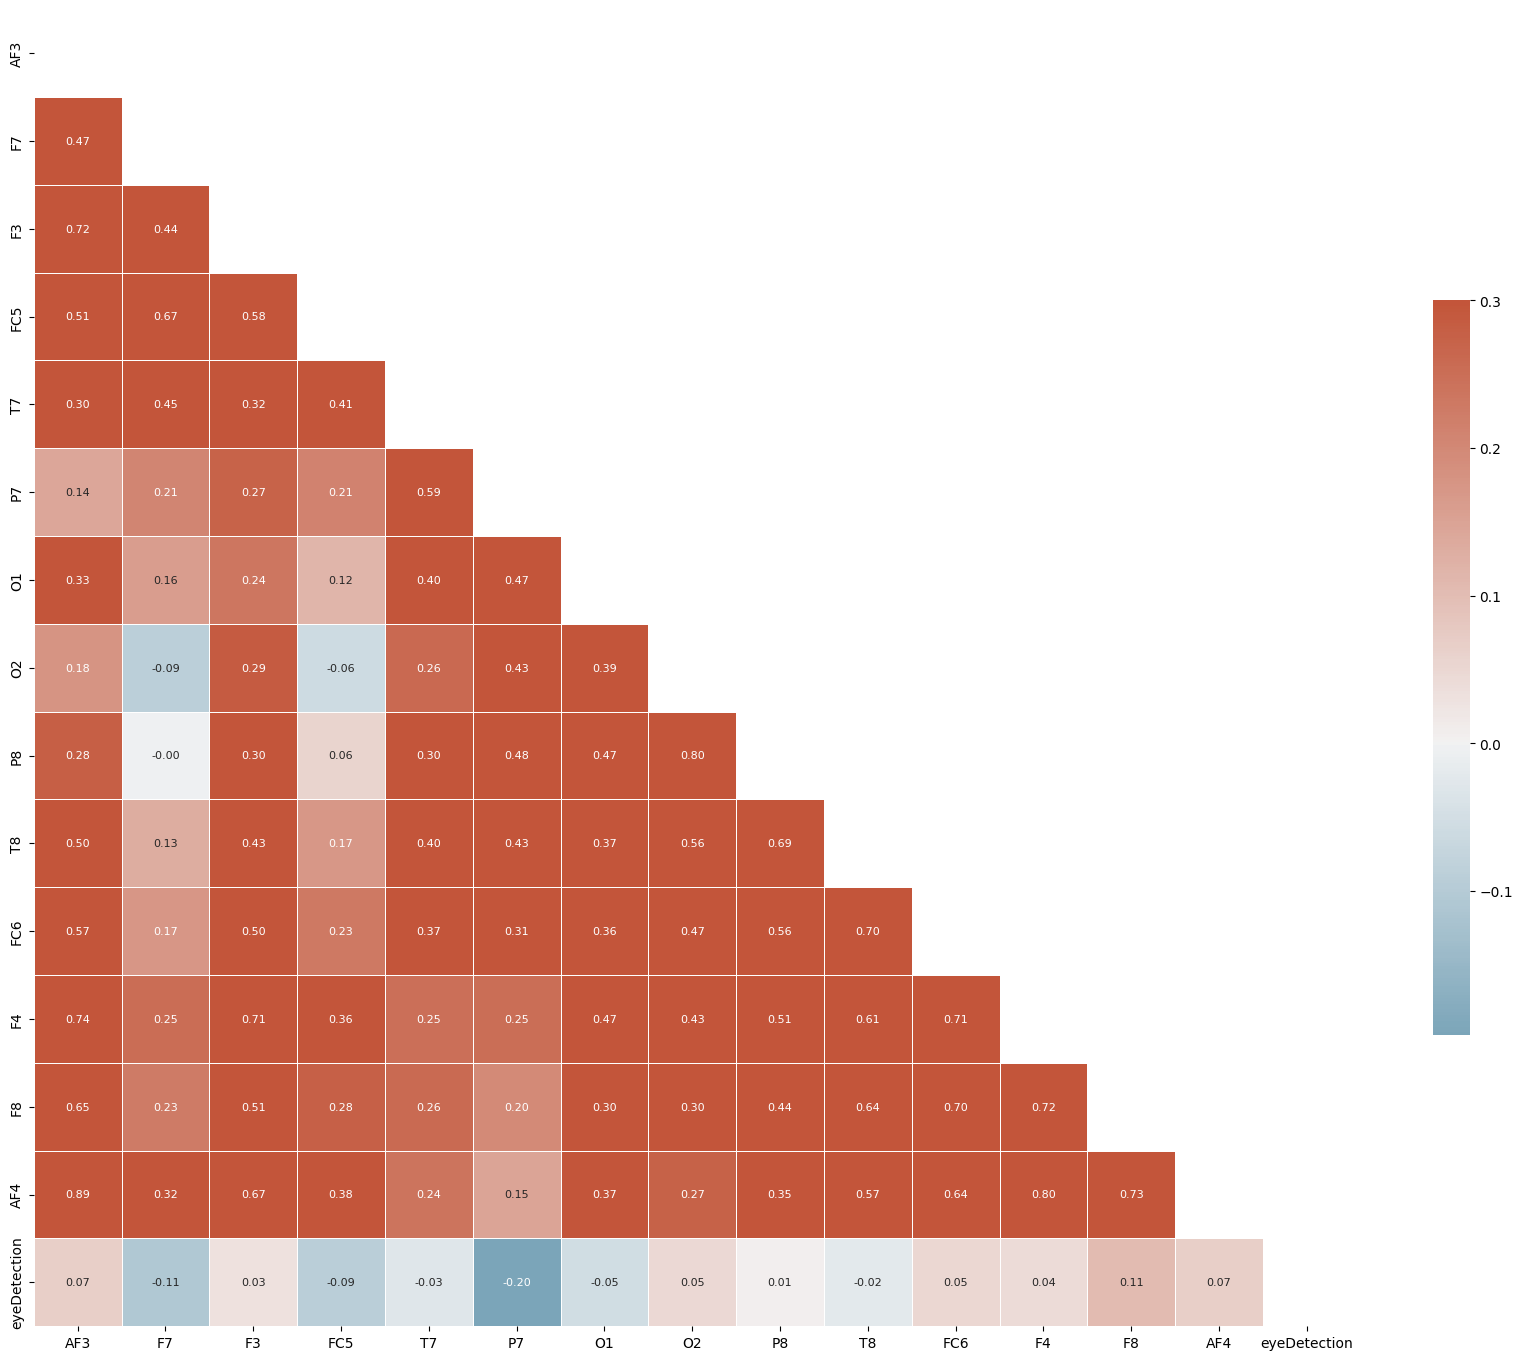

In [6]:
import arff
import seaborn as sns
import matplotlib.pyplot as plt

data_path = r'/data/eeg_eyestate/EEG_Eye_State.arff'

with open(data_path, 'r') as f:
    raw = arff.load(f)

columns = [attr[0] for attr in raw['attributes']]
df = pd.DataFrame(raw['data'], columns=columns)

df = df.drop([10386,11509, 898]) 


data = df

corr = data.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(17, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=0.3, 
    center=0,
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.5},  
    annot=True,  
    fmt=".2f",   
    annot_kws={"size": 8},  
    xticklabels=corr.columns,  
    yticklabels=corr.columns  
)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

plt.tight_layout()
plt.show()

plt.close()

In [7]:
path = r'/data/eeg_eyestate/EEG_Eye_State.csv'
target_column = 'eyeDetection'
reader = DataReader(path, target_columns=[target_column])
X,y = reader.get_X_y()

In [8]:
X = X.drop(columns=["Timestamp"])
preprocessor = PreProcessingTransformer(target_column=[target_column],numeric_features=X.columns.to_list(),categorical_features=[], handle_unknown='ignore')
preprocessor.fit(X, y)

X_array, y_array = preprocessor.transform(X, y)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import norm

class ConfidenceInterval:
  def __init__(self, data, alpha) -> None:
    bootstrap = Bootstrap(data)
    bootstrap.calculate_bootstrap(bootstraps=9000, estimator=np.mean)
    self.mean = bootstrap.mean()
    self.stand = bootstrap.std()
    self.z = norm.ppf(1 - (alpha/2))

  def calculate_lower_bound(self):
    return self.mean - (self.z * self.stand)

  def calculate_upper_bound(self):
    return self.mean + (self.z * self.stand)

class Bootstrap:

    def __init__(self, X):
        self.X = X
        self.bootstraps = []

    def calculate_bootstrap(self, bootstraps=9000, estimator=np.mean):
        for i in range(bootstraps):
            X_sample = np.random.choice(self.X, size=len(self.X), replace=True)
            o = estimator(X_sample)
            self.bootstraps.append(o)

    def mean(self):
        mean = np.sum(self.bootstraps) / len(self.bootstraps)
        return mean

    def std(self):
        mean = self.mean()
        sum_of_diff = 0
        for xi in self.bootstraps:
            sum_of_diff += (xi-mean) * (xi-mean)
        stand = sum_of_diff/ (len(self.bootstraps) - 1)
        stand = np.sqrt(stand)
        return stand
    

K_range = range(1, 51)
n_runs = 30 
alpha = 0.05 # alpha para o intervalo de confiança

all_inertias = np.zeros((len(K_range), n_runs)) 

for i, k in enumerate(K_range):
    for run in range(n_runs):
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=run)
        kmeans.fit(X_array) 
        all_inertias[i, run] = kmeans.inertia_

means = []
lower_bounds = []
upper_bounds = []

# o bootstrap está sendo calculado dentro da classe confidence interval
for i, k in enumerate(K_range):
    ci = ConfidenceInterval(all_inertias[i, :], alpha)  
    means.append(ci.mean)
    lower_bounds.append(ci.calculate_lower_bound())
    upper_bounds.append(ci.calculate_upper_bound())

single_run_inertias = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(X_array) 
    single_run_inertias.append(kmeans.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(K_range, means, marker='o', label='Inércia Média')
ax1.fill_between(K_range, lower_bounds, upper_bounds, alpha=0.2, label='Intervalo de Confiança (95%)')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inércia (Soma dos Erros Quadráticos)')
ax1.set_title('Método do Cotovelo com Intervalo de Confiança')
ax1.grid(True)
ax1.legend()

ax2.plot(K_range, single_run_inertias, marker='o', color='green', label='Inércia (1 Run)')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Inércia (Soma dos Erros Quadráticos)')
ax2.set_title('Método do Cotovelo (Única Execução)')
ax2.grid(True)
ax2.legend()

focus_range = range(1, 16)
ax1.set_xlim(0.5, 15.5)
ax1.set_xticks(focus_range)

ax2.set_xlim(0.5, 15.5)
ax2.set_xticks(focus_range)


plt.tight_layout()
plt.show()
plt.close()

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
kmeans.fit(X_array)
X['cluster'] = kmeans.labels_
X


In [ ]:
import pandas as pd

# Caminho original e novo arquivo corrigido
input_path = path
cleaned_path = r'/data/isa/clean_EEG_Eye_State.arff'

# Leitura do arquivo linha a linha
with open(input_path, 'r') as f:
    lines = f.readlines()

# Separar cabeçalho e dados
header_lines = []
data_lines = []
in_data_section = False
expected_num_values = 0

for line in lines:
    stripped = line.strip()
    if not in_data_section:
        header_lines.append(line)
        if stripped.lower().startswith('@attribute'):
            expected_num_values += 1
        elif stripped.lower() == '@data':
            in_data_section = True
    else:
        data_lines.append(line)

# Filtrar linhas válidas
clean_data_lines = []
corrupted_count = 0

for line in data_lines:
    values = line.strip().split(',')
    if len(values) == expected_num_values:
        clean_data_lines.append(line)
    else:
        corrupted_count += 1

# Escreve novo arquivo corrigido
with open(cleaned_path, 'w') as f:
    f.writelines(header_lines)
    f.writelines(clean_data_lines)

print(f"Linhas corrompidas removidas: {corrupted_count}")

import arff

with open(cleaned_path, 'r') as f:
    raw = arff.load(f)

columns = [attr[0] for attr in raw['attributes']]
df = pd.DataFrame(raw['data'], columns=columns)

df.head()

